In [1]:
from fastai.collab import *
from fastai.tabular import *

## Anime Recommendation

In [2]:
path= Path('../../data/anime_recommendation')

In [3]:
ratings = pd.read_csv(path/'rating.csv')
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [32]:
ratings.rating.describe()

count    7.813737e+06
mean     6.144030e+00
std      3.727800e+00
min     -1.000000e+00
25%      6.000000e+00
50%      7.000000e+00
75%      9.000000e+00
max      1.000000e+01
Name: rating, dtype: float64

In [4]:
anime_list = pd.read_csv(path/'anime.csv')
anime_list.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [5]:
len(ratings)

7813737

In [6]:
rating_anime = ratings.merge(anime_list[['anime_id', 'name']])
rating_anime.head()

,user_id,anime_id,rating,name
0,1,20,-1,Naruto
1,3,20,8,Naruto
2,5,20,6,Naruto
3,6,20,-1,Naruto
4,10,20,-1,Naruto


In [13]:
len(rating_anime.name.unique())

11196

In [7]:
data = CollabDataBunch.from_df(rating_anime, seed=42, valid_pct=0.1, item_name='name')

In [8]:
data.show_batch()

user_id,name,target
49627,Juubee Ninpuuchou,8.0
7293,Love Hina Again,6.0
5538,Kurokami The Animation,9.0
39116,Black Lagoon: The Second Barrage,10.0
63696,No Game No Life,9.0


In [9]:
y_range = [-2,11]

In [34]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

In [36]:
learn.load('dotprod');

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


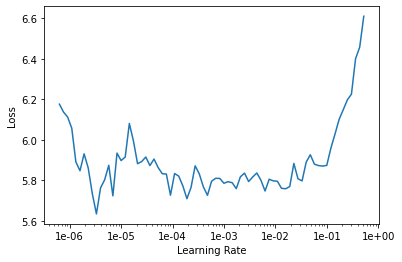

In [37]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [38]:
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,time
0,5.705852,5.911939,08:44
1,5.970082,5.936195,08:44
2,5.969931,5.929643,08:39
3,5.874405,5.915240,08:44
4,5.748025,5.911481,08:31


In [39]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [ ]:
learn.load('dotprod');

In [15]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(73261, 40)
  (i_weight): Embedding(11036, 40)
  (u_bias): Embedding(73261, 1)
  (i_bias): Embedding(11036, 1)
)

In [40]:
g = rating_anime.groupby('name')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Death Note', 'Sword Art Online', 'Shingeki no Kyojin', 'Code Geass: Hangyaku no Lelouch', 'Elfen Lied',
       'Angel Beats!', 'Naruto', 'Fullmetal Alchemist', 'Fullmetal Alchemist: Brotherhood', 'Toradora!'], dtype=object)

### Movie bias

In [41]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [42]:
mean_ratings = rating_anime.groupby('name')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [43]:
item0 = lambda o:o[0]

In [44]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3335), 'Pupa', 3.1613746731415766),
 (tensor(-0.2157), 'Boku no Pico', 3.5757575757575757),
 (tensor(-0.1394),
  'Dragon Ball Z Movie 11: Super Senshi Gekiha!! Katsu no wa Ore da',
  4.351637764932563),
 (tensor(-0.1153), 'Diabolik Lovers', 4.488091737724199),
 (tensor(-0.1108), 'Glasslip', 4.596376252891288),
 (tensor(-0.1075),
  'Naruto: Akaki Yotsuba no Clover wo Sagase',
  4.476779252110977),
 (tensor(-0.0852),
  'Dragon Ball Z Movie 02: Kono Yo de Ichiban Tsuyoi Yatsu',
  4.74),
 (tensor(-0.0819),
  'Naruto Movie 2: Dai Gekitotsu! Maboroshi no Chiteiiseki Dattebayo!',
  4.951397712833545),
 (tensor(-0.0816),
  'Naruto Movie 3: Dai Koufun! Mikazuki Jima no Animaru Panikku Dattebayo!',
  4.8946115927248),
 (tensor(-0.0787), 'Corpse Party: Missing Footage', 4.5197811447811445),
 (tensor(-0.0738), 'Toradora!: SOS!', 4.732433505359269),
 (tensor(-0.0737),
  'Dragon Ball Z Movie 04: Super Saiyajin da Son Gokuu',
  4.719033232628399),
 (tensor(-0.0720),
  'Naruto: Dai Katsuge

In [55]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:25]

[(tensor(0.7210), 'Steins;Gate', 8.126795623087693),
 (tensor(0.7093), 'Fullmetal Alchemist: Brotherhood', 8.028933018637584),
 (tensor(0.6179), 'Hunter x Hunter (2011)', 7.924081632653062),
 (tensor(0.6179), 'Code Geass: Hangyaku no Lelouch R2', 7.76594340400957),
 (tensor(0.6112), 'Tengen Toppa Gurren Lagann', 7.709572322490562),
 (tensor(0.6039), 'Clannad: After Story', 7.835275008401479),
 (tensor(0.5896), 'Code Geass: Hangyaku no Lelouch', 7.641243956995454),
 (tensor(0.5892), 'Death Note', 7.556176919166243),
 (tensor(0.5599), 'Monster', 7.809098824553765),
 (tensor(0.5571), 'Cowboy Bebop', 7.5585144109871685),
 (tensor(0.5521), 'Shigatsu wa Kimi no Uso', 7.740262489415749),
 (tensor(0.5498), 'Great Teacher Onizuka', 7.590835030549898),
 (tensor(0.5446), 'Gintama', 7.7752312022517085),
 (tensor(0.5377), 'Mushishi', 7.657909765848087),
 (tensor(0.5238), 'Kimi no Na wa.', 8.297862664847658),
 (tensor(0.5120), 'Baccano!', 7.473803071364047),
 (tensor(0.5024), 'Gintama&#039;', 7.7119

### Movie weights

In [46]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [47]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [48]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [49]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.6426), 'Pupa'),
 (tensor(1.5783), 'Boku no Pico'),
 (tensor(1.0954), 'Glasslip'),
 (tensor(0.9007), 'Corpse Party: Missing Footage'),
 (tensor(0.8849), 'Aki-Sora'),
 (tensor(0.8542), 'Oniichan no Koto nanka Zenzen Suki ja Nai n da kara ne!!'),
 (tensor(0.8129), 'Toradora!: SOS!'),
 (tensor(0.7888), 'Tenshi Kinryouku'),
 (tensor(0.7881),
  'Dragon Ball Z Movie 11: Super Senshi Gekiha!! Katsu no wa Ore da'),
 (tensor(0.7736), 'Okusama ga Seitokaichou!')]

In [50]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.4599), 'Sen to Chihiro no Kamikakushi'),
 (tensor(-1.3138), 'Mononoke Hime'),
 (tensor(-1.2568), 'Howl no Ugoku Shiro'),
 (tensor(-1.1386), 'Tonari no Totoro'),
 (tensor(-1.1171), 'Death Note'),
 (tensor(-1.0695), 'Shingeki no Kyojin'),
 (tensor(-1.0219), 'Fullmetal Alchemist: Brotherhood'),
 (tensor(-0.9832), 'Ouran Koukou Host Club'),
 (tensor(-0.9098), 'Tenkuu no Shiro Laputa'),
 (tensor(-0.9097), 'Majo no Takkyuubin')]

In [51]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [52]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(2.6077e-08), 'Danshi Koukousei no Nichijou'),
 (tensor(1.3039e-08), 'Kimi ni Todoke'),
 (tensor(9.3132e-09), 'Pokemon: Kesshoutou no Teiou Entei'),
 (tensor(6.5193e-09), 'One Punch Man: Road to Hero'),
 (tensor(1.8626e-09), 'Clannad'),
 (tensor(-3.7253e-09), 'Nana'),
 (tensor(-1.1176e-08), 'Nodame Cantabile'),
 (tensor(-1.4901e-08), 'Kaichou wa Maid-sama!'),
 (tensor(-1.4901e-08),
  'Mahou Shoujo Madoka★Magica Movie 3: Hangyaku no Monogatari'),
 (tensor(-1.7695e-08), 'Deadman Wonderland OVA')]

In [53]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-3.2224e-07), 'Tokyo Ghoul'),
 (tensor(-2.2352e-07), 'Erementar Gerad'),
 (tensor(-2.1979e-07), 'Code Geass: Hangyaku no Lelouch'),
 (tensor(-2.0862e-07), 'Steins;Gate'),
 (tensor(-2.0373e-07), 'Grisaia no Kajitsu'),
 (tensor(-2.0233e-07), 'Break Blade 5: Shisen no Hate'),
 (tensor(-2.0117e-07), 'Tales of the Abyss'),
 (tensor(-1.9977e-07), 'Aa! Megami-sama! (TV)'),
 (tensor(-1.9837e-07), 'Ookami to Koushinryou'),
 (tensor(-1.9744e-07), 'Fate/stay night')]

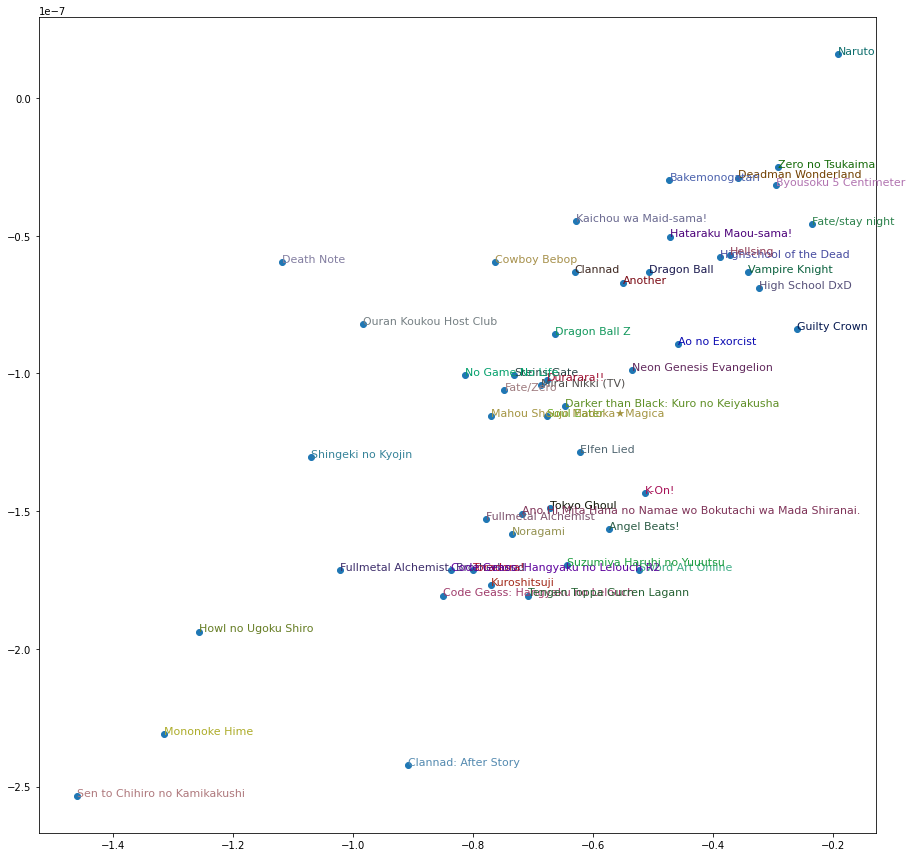

In [54]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()